# PBO on LQR

## Define paramters

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import jax
import os
import json

parameters = json.load(open("parameters.json"))
env_seed = parameters["env_seed"]

# Sample collection
max_discrete_state = parameters["max_discrete_state"]
n_discrete_states = parameters["n_discrete_states"]
max_discrete_action = parameters["max_discrete_action"]
n_discrete_actions = parameters["n_discrete_actions"]
n_samples = n_discrete_states * n_discrete_actions

# Weights collection
n_weights = parameters["n_weights"]
weights_filtering = True

# Q function
action_range_on_max = parameters["action_range_on_max"]
n_actions_on_max = parameters["n_actions_on_max"]

# Trainings
max_bellman_iterations = parameters["max_bellman_iterations"]
training_steps = 3200
fitting_steps = 1
batch_size_samples = n_samples
batch_size_weights = n_weights
learning_rate = {"first": 0.01, "last": 0.00001, "duration": training_steps * fitting_steps * n_samples // batch_size_samples}

# Visualisation of errors and performances
max_bellman_iterations_validation = max_bellman_iterations + 5

# Search for an unused seed
max_used_seed = 0
for file in os.listdir("figures/data/PBO_custom_linear/"):
    if int(file.split("_")[0]) == max_bellman_iterations and int(file.split("_")[2]) == n_samples and int(file.split("_")[3]) == n_weights and int(file.split("_")[4][:-4]) > max_used_seed:
        max_used_seed = int(file.split("_")[4][:-4])
max_used_seed

# keys
env_key = jax.random.PRNGKey(env_seed)
seed = max_used_seed + 1
key = jax.random.PRNGKey(seed)
shuffle_key, q_network_key, random_weights_key, pbo_network_key = jax.random.split(key, 4)

## Define environment

In [2]:
import numpy as np

from pbo.environment.linear_quadratic import LinearQuadraticEnv


discrete_states = np.linspace(-max_discrete_state, max_discrete_state, n_discrete_states)
state_box_half_size = max_discrete_state / n_discrete_states
discrete_states_boxes = np.linspace(
    -max_discrete_state - state_box_half_size, max_discrete_state + state_box_half_size, n_discrete_states + 1
)

discrete_actions = np.linspace(-max_discrete_action, max_discrete_action, n_discrete_actions)
action_box_half_size = max_discrete_action / n_discrete_actions
discrete_actions_boxes = np.linspace(
    -max_discrete_action - action_box_half_size, max_discrete_action + action_box_half_size, n_discrete_actions + 1
)

env = LinearQuadraticEnv(env_key, max_init_state=max_discrete_state)

Transition: s' = As + Ba
Transition: s' = 0.7204725742340088s + -0.5264108180999756a
Reward: Qs² + Ra² + 2 Ssa
Reward: -0.13297832012176514s² + -0.8039400577545166a² + 0.2581009864807129sa


## Collect samples

### Samples on the mesh

In [3]:
import jax.numpy as jnp

from pbo.sample_collection.replay_buffer import ReplayBuffer


n_samples = n_discrete_states * n_discrete_actions
replay_buffer = ReplayBuffer()

for state in discrete_states:
    for action in discrete_actions:
        env.reset(jnp.array([state]))
        next_state, reward, absorbing, _ = env.step(jnp.array([action]))

        replay_buffer.add(jnp.array([state]), jnp.array([action]), reward, next_state, absorbing)

replay_buffer.cast_to_jax_array()

### Visualize samples

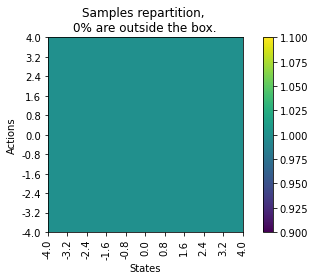

In [4]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh


samples_count, n_outside_boxes, _ = count_samples(replay_buffer.states, replay_buffer.actions, discrete_states_boxes, discrete_actions_boxes, replay_buffer.rewards)
samples_visu_mesh = TwoDimesionsMesh(discrete_states, discrete_actions, sleeping_time=0)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box."
)


## Collect weights

In [5]:
from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_q import LQRQ
from pbo.weights_collection.weights_buffer import WeightsBuffer


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
q = LQRQ(
    state_dim=1,
    action_dim=1,
    n_actions_on_max=n_actions_on_max,
    action_range_on_max=action_range_on_max,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=None,
    learning_rate=None,
    zero_initializer=True,
)
validation_initial_weight = q.to_weights(q.params)

weights_buffer = WeightsBuffer()
weights_buffer.add(validation_initial_weight)

q_random = LQRQ(
    state_dim=1,
    action_dim=1,
    n_actions_on_max=n_actions_on_max,
    action_range_on_max=action_range_on_max,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    learning_rate=None,
    zero_initializer=False,
)

while len(weights_buffer) < n_weights:
    weights = q_random.random_init_weights()
    if not weights_filtering or q_random.to_params(weights)["LQRQNet"]["m"] < 0:
        weights_buffer.add(weights)

weights_buffer.cast_to_jax_array()

## Train linear PBO

  0%|          | 0/3200 [00:00<?, ?it/s]

[0. 0. 0.]
[-0.13319667  0.12905227 -0.80365163]
[-0.19117458  0.17171045 -0.83540231]
[-0.21355048  0.18817388 -0.84765613]
[-0.22174475  0.19420293 -0.85214359]
[-0.22468758  0.19636816 -0.85375518]
[-0.22573702  0.19714031 -0.85432988]
[-0.22611031  0.19741496 -0.85453433]
Optimal weights
[-0.22707027  0.19779846 -0.8541705 ]


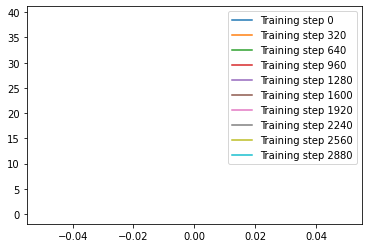

In [6]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader
from pbo.networks.learnable_pbo import CustomLinearPBO


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)
pbo_custom_linear = CustomLinearPBO(q, max_bellman_iterations, False, pbo_network_key, learning_rate)
importance_iteration = jnp.ones(max_bellman_iterations + 1)

cumulative_l2_loss = np.zeros((training_steps, fitting_steps)) * np.nan

for training_step in tqdm(range(training_steps)):
    params_target = pbo_custom_linear.params
    for fitting_step in range(fitting_steps):
        data_loader_weights.shuffle()
        for batch_weights in data_loader_weights:
            data_loader_samples.shuffle()
            for batch_samples in data_loader_samples:
                pbo_custom_linear.params, pbo_custom_linear.optimizer_state, l2_loss = pbo_custom_linear.learn_on_batch(
                    pbo_custom_linear.params, params_target, pbo_custom_linear.optimizer_state, batch_weights, batch_samples, importance_iteration
                )
        cumulative_l2_loss[training_step, fitting_step] = l2_loss

weights = np.zeros((max_bellman_iterations_validation + 1, q.weights_dimension))


batch_iterated_weights = validation_initial_weight.reshape((1, -1))
for bellman_iteration in range(max_bellman_iterations_validation + 1):
    weights[bellman_iteration] = batch_iterated_weights[0]
    print(weights[bellman_iteration])

    batch_iterated_weights = pbo_custom_linear(pbo_custom_linear.params, batch_iterated_weights)

print("Optimal weights")
print(env.optimal_weights)

for training_step in range(0, training_steps, max(training_steps // 10, 1)):
    plt.plot(cumulative_l2_loss[training_step], label=f"Training step {training_step}")
plt.legend()
plt.show()

## Save data

In [7]:
np.save(f"figures/data/PBO_custom_linear/{max_bellman_iterations}_W_{n_samples}_{n_weights}_{seed}.npy", weights)
np.save(f"figures/data/PBO_custom_linear/{max_bellman_iterations}_Pi_{n_samples}_{n_weights}_{seed}.npy", env.greedy_V(weights))

## Visualise

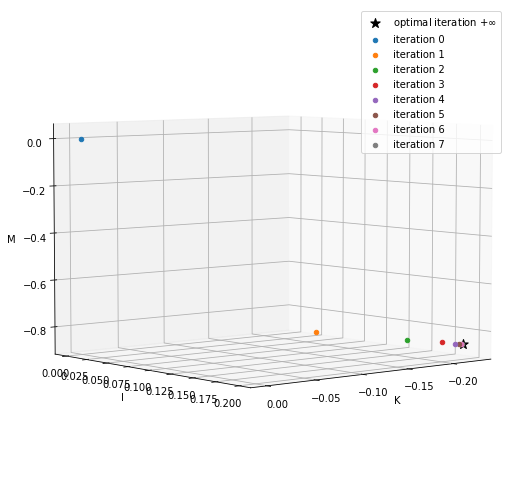

In [8]:
from pbo.utils.lqr_weights_viewer import visualize

weights[np.abs(weights) > 20] = np.nan

visualize(weights, env.optimal_weights)

## Understand

In [9]:
ideal_params = {"CustomLinearPBONet": {"bias": None, "slope": None}}
ideal_params["CustomLinearPBONet"]["bias"] = jnp.array([env.Q[0, 0], env.S[0, 0], env.R[0, 0]]).reshape((1, 3))
ideal_params["CustomLinearPBONet"]["slope"] = jnp.array([env.A[0, 0] ** 2, env.A[0, 0] * env.B[0, 0],env.B[0, 0] ** 2]).reshape((1, 3))

print("Current loss:", pbo_custom_linear.learn_on_batch(
    pbo_custom_linear.params, params_target, pbo_custom_linear.optimizer_state, batch_weights, batch_samples, importance_iteration
)[-1])
print("Loss with optimal params:", pbo_custom_linear.learn_on_batch(
    ideal_params, params_target, pbo_custom_linear.optimizer_state, batch_weights, batch_samples, importance_iteration
)[-1])

Current loss: 2.8267466e-06
Loss with optimal params: 1.3636626e-06


In [10]:
print("Current bias:", pbo_custom_linear.params["CustomLinearPBONet"]["bias"][0])

Current bias: [-0.13319667  0.12905227 -0.80365163]


In [11]:
print("Optimal bias:", jnp.array([env.Q[0, 0], env.S[0, 0], env.R[0, 0]]))

Optimal bias: [-0.13297832  0.1290505  -0.80394006]


In [12]:
print("Current slope:", pbo_custom_linear.params["CustomLinearPBONet"]["slope"][0])

Current slope: [ 0.5154823  -0.37927434  0.28229573]


In [13]:
print("Optimal slope:", jnp.array([env.A[0, 0] ** 2, env.A[0, 0] * env.B[0, 0],env.B[0, 0] ** 2]))

Optimal slope: [ 0.51908076 -0.37926456  0.27710834]
